In [2]:
# %pip install pandas
# %pip install langchain langchain_community
# %pip install neo4j
# %pip install langchain_openai
# %pip install python-dotenv
# %pip install chromadb
# %pip install "numpy<2"
# %pip install networkx
# %pip install matplotlib
# %pip install dowhy

In [3]:
import pandas as pd
import os
from langchain_community.graphs import Neo4jGraph
from langchain_core.messages import AIMessage
from langchain_openai import AzureChatOpenAI, AzureOpenAIEmbeddings
from dotenv import load_dotenv

In [4]:
os.environ['NEO4J_URI'] = 'bolt://localhost:7690'
os.environ['NEO4J_USERNAME'] = 'neo4j'
os.environ['NEO4J_PASSWORD'] = 'Password@123'
graph = Neo4jGraph()

In [5]:
load_dotenv()

# os.environ["AZURE_OPENAI_API_KEY"] = os.getenv("AZURE_OPENAI_API_KEY")
# os.environ["AZURE_OPENAI_ENDPOINT"] = "https://sriks-openai.openai.azure.com/"
# os.environ["AZURE_OPENAI_API_VERSION"] = "2024-05-01-preview"
# os.environ["AZURE_OPENAI_CHAT_DEPLOYMENT"] = "gpt-4o"
# os.environ["AZURE_OPENAI_EMBEDDINGS_DEPLOYMENT"] = "text-embedding-ada-002"

# llm = AzureChatOpenAI(
#     openai_api_version=os.environ["AZURE_OPENAI_API_VERSION"],
#     azure_deployment=os.environ["AZURE_OPENAI_CHAT_DEPLOYMENT"],
# )

# embeddings = AzureOpenAIEmbeddings(
#     openai_api_version=os.environ["AZURE_OPENAI_API_VERSION"],
#     azure_deployment=os.environ["AZURE_OPENAI_EMBEDDINGS_DEPLOYMENT"],
# )

In [6]:
# examples = [
#     {
#         "question": "What is the root cause request id 8ff8696695aa73588ac454809741e2ea",
#         "query": "MATCH (n)-[r:DEPENDS_ON]->(m) where n.id <> 'ROOT' OR m.id <> 'ROOT' and r.operationId = 8ff8696695aa73588ac454809741e2ea RETURN n.id, r.duration, r.operation_Name, m.id ORDER BY r.duration DESC LIMIT 3",
#     },
#     {
#         "question": "what is the longest running operation",
#         "query": "MATCH (n)-[r:DEPENDS_ON]->(m) where n.id <> 'ROOT' OR m.id <> 'ROOT' RETURN n.id, r.duration, r.operation_Name, m.id ORDER BY r.duration DESC LIMIT 3",
#     }
# ]

In [7]:
# from langchain.chains import GraphCypherQAChain
# from langchain_core.prompts import FewShotPromptTemplate, PromptTemplate
# from langchain_core.example_selectors import SemanticSimilarityExampleSelector, MaxMarginalRelevanceExampleSelector
# from langchain.vectorstores import Chroma
# from langchain.chains.llm import LLMChain
# from langchain.chains.graph_qa.cypher import construct_schema
# from langchain.chains import SimpleSequentialChain, SequentialChain
# from langchain.agents import AgentType, initialize_agent, load_tools

# # load human intervention tools
# tools = load_tools(
#     ["human"], llm
# )

# graph.refresh_schema()

# QA_GENERATION_TEMPLATE = """
#        Task: answer the question you are given based on the context provided.
#        Instructions:
#         You are an assistant that helps to form nice and human understandable answers. 
#         Use the context information provided to generate a well organized and comprehensve answer to the user's question. 
#         When the provided information contains multiple elements, structure your answer as a bulleted or numbered list to enhance clarity and readability.
#         You must use the information to construct your answer. 
#         The provided information is authoritative; do not doubt it or try to use your internal knowledge to correct it. 
#         Make the answer sound like a response to the question without mentioning that you based the result on the given information. 
#         If there is no information provided, say that the knowledge base returned empty results.

#         Here's the information:
#         {context}

#         Question: {question}
#         Answer:
#             """
# EXAMPLES_PROMPT_TEMPLATE = """   
#                 Input: {question},
#                 Output: {query}
#             """

# qaPrompt = PromptTemplate(input_variables=["context", "question"], template=QA_GENERATION_TEMPLATE)

# example_prompt = PromptTemplate(input_variables=["question", "query"], template=EXAMPLES_PROMPT_TEMPLATE)

# cypherPromptTemplate = """
# You are an expert Neo4j Developer translating user questions into Cypher to answer questions.
# Convert the user's question based on the schema.
# Instructions: Use only the provided relationship types and properties in the schema.
# Do not use any other relationship types or properties that are not provided.
# Schema:
# {schema}

# Note: Do not include any explanations or apologies in your responses.
# Do not respond to any questions that might ask anything else than for you to construct a Cypher statement.
# Do not include any text except the generated Cypher statement.

# Important: In the generated Cypher query, the RETURN statement must explicitly include the property values used in the query's filtering condition, alongside the main information requested from the original question.

# Question: {question}
# input:
# """

# similaritySelector = SemanticSimilarityExampleSelector.from_examples(
#     examples=examples, 
#     embeddings=embeddings, 
#     k=1,
#     vectorstore_cls=Chroma
# )

# cypherPrompt = FewShotPromptTemplate(
#     example_selector=similaritySelector,
#     example_prompt=example_prompt,
#     input_variables=["question", "schema"], 
#     prefix=cypherPromptTemplate,
#     suffix="the question is:{question}",
# )

# cypherqachain = GraphCypherQAChain.from_llm(
#     llm = llm,
#     return_intermediate_steps=True,
#     validate_cypher=True,
#     graph=graph, 
#     verbose=True,
#     k=3,
#     use_function_response=True,
#     cypherPrompt=cypherPrompt,
#     return_direct=True,
#     output_key="input",
# ) 

# schema  = construct_schema(graph.get_structured_schema, [], [])

In [8]:
# # Test cypher chain invocation
# cypherqachain.invoke({"query": "which nodes has max azure dependencies"})

In [10]:
# import matplotlib
# nx.draw(graph, with_labels=True, font_weight='bold')

[Work In Progress]

In [28]:
pc_df = pd.read_csv('pc.csv')
len(pc_df)

In [29]:
def minimize_scale(x):
    if x['CounterName'] == 'memoryWorkingSetBytes':
        return x['avg_CounterValue'] / 1000000
    elif x['CounterName'] == 'cpuUsageNanoCores':
        return x['avg_CounterValue'] / 1e9
    
def parseServiceName(x):
    splits = x.split('/')
    servicename = splits[-1]
    return servicename

def parseInstanceId(x):
    splits = x.split('/')
    instanceid = splits[-2]
    return instanceid

# reducing the scale of countervalue
regex_filter_for_services = 'api'
pc_df['avg_CounterValue'] = pc_df['avg_CounterValue'].astype(float) 
pc_df['avg_CounterValue'] = pc_df.apply(minimize_scale, axis=1)
pc_df['ServiceName'] = pc_df['InstanceName'].apply(lambda x: parseServiceName(x))
# only keep rows that have services in service name
# pc_df = pc_df[pc_df['ServiceName'] in services]
pc_df['InstanceId'] = pc_df['InstanceName'].apply(lambda x: parseInstanceId(x))
pc_df.drop(columns=['InstanceName'], inplace=True)
pc_df.rename(columns={'TimeGenerated [UTC]': 'timestamp'}, inplace=True)
# only keep rows that have api in service name
# to make it general, we can get the services from the user and then filter based on that
pc_df = pc_df[pc_df['ServiceName'].str.contains(regex_filter_for_services)]
pc_df.head(1)

,timestamp,CounterName,avg_CounterValue,ServiceName,InstanceId
2,"12/7/2024, 3:00:00.000 pm",cpuUsageNanoCores,0.000647,notification-api,dbcaa474-d058-4f26-ad2b-168a62be0dab


In [30]:
# Considering only CPU Usage
cpu_pc_df = pc_df[pc_df['CounterName'].str.contains('cpuUsageNanoCores')]

In [31]:
def format_services_for_cypher(services):
   services = cpu_pc_df['ServiceName'].unique().tolist()
   services = [f'"{service}"' for service in services]
   services = "[" + ",".join(services) + "]"
   return services
services = format_services_for_cypher(cpu_pc_df['ServiceName'].unique().tolist())
print(services)

["notification-api","address-api","reports-api","utex-api","note-api","crm-api","people-api","configuration-api","uniquenumbergenerator-api","shift-api","authorization-api","users-api","billing-api","solomon-api","docuware-api","roles-api","v4-api","u2-api","rules-api","payroll-api","fallout-api","ingestion-api","careattend-api","intframework-api"]


[]


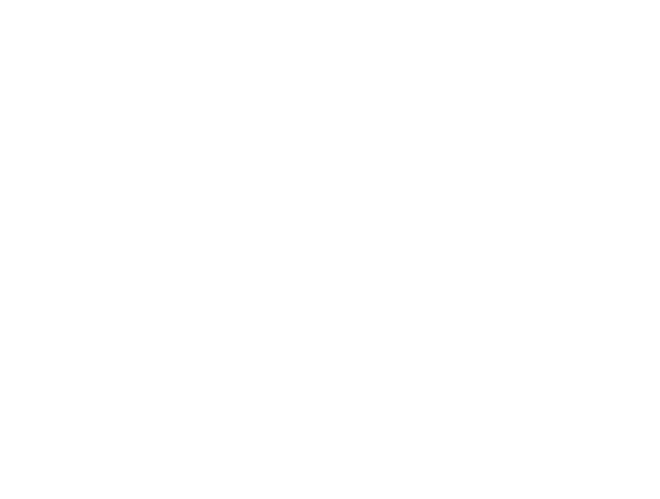

In [37]:
import networkx as nx
from neo4j import GraphDatabase
import matplotlib

driver = GraphDatabase.driver(os.environ['NEO4J_URI'], auth=("neo4j", os.environ['NEO4J_PASSWORD']))

def graph_from_cypher(operationId, services):
    G = nx.MultiDiGraph()
    # write a query to get all nodes except one that contains APIM In node id
    # query = "MATCH"
    query = f"MATCH (n:cloudRoleName)-[r:DEPENDS_ON]-(m:cloudRoleName) where (r.operationId = '{operationId}' and n.id in {services} or m.id in {services} ) RETURN n, r, m"
    results = driver.session().run(query)
    nodes = list(results.graph()._nodes.values())
    for node in nodes:
        G.add_node(node._properties['id'], labels=node._labels, properties=node._properties)
    rels = list(results.graph()._relationships.values())
    for rel in rels:
        G.add_edge(rel.start_node._properties['id'], rel.end_node._properties['id'], key=rel.element_id, type=rel.type, properties=rel._properties)
    return G, nodes, rels

graph, nodes, rels = graph_from_cypher("792fbcbe80b94771a8bd96c4211312b9", services)
nx.draw(graph, with_labels=True, font_weight='bold')
print(nodes)

In [17]:
services_in_graph = [node._properties['id'] for node in nodes]
print(services_in_graph)

['rules-api', 'payroll-api', 'people-api', 'authorization-api', 'u2-api', 'v4-api']


In [18]:
f_pc_df = pc_df[pc_df.apply(lambda x: x['ServiceName'] in services_in_graph, axis=1)]
len(f_pc_df)

1818

In [20]:
# group by timestamp, servicename, countername and average the values
g_pc_df = f_pc_df.groupby(['timestamp', 'ServiceName']).max().reset_index()
# concatenate servicename and countername to form a unique identifier
# g_pc_df['ServiceCounter'] = g_pc_df['ServiceName'] + '_' + g_pc_df['CounterName']
g_pc_df.drop(columns=['CounterName', 'InstanceId'], inplace=True)
# pivot and add new columns for each countername
# pc_df = pc_df.pivot(index=['timestamp'], columns='ServiceCounter', values='avg_CounterValue').reset_index()
g_pc_df.head(5)

,timestamp,ServiceName,avg_CounterValue
0,"12/7/2024, 2:10:00.000 pm",authorization-api,195.237478
1,"12/7/2024, 2:10:00.000 pm",payroll-api,166.074778
2,"12/7/2024, 2:10:00.000 pm",people-api,222.701978
3,"12/7/2024, 2:10:00.000 pm",rules-api,154.964787
4,"12/7/2024, 2:10:00.000 pm",u2-api,321.933312


In [25]:
pcs = g_pc_df.pivot(index=['timestamp'], columns='ServiceName', values='avg_CounterValue').reset_index()
pcs.head(5)

ServiceName,timestamp,authorization-api,payroll-api,people-api,rules-api,u2-api,v4-api
0,"12/7/2024, 2:10:00.000 pm",195.237478,166.074778,222.701978,154.964787,321.933312,188.207104
1,"12/7/2024, 2:15:00.000 pm",209.804493,168.015462,260.396646,160.246170,453.468979,243.386778
2,"12/7/2024, 2:20:00.000 pm",211.791053,168.011366,246.176154,159.637504,568.980275,320.584909
3,"12/7/2024, 2:25:00.000 pm",215.077683,170.391142,275.150438,164.397875,672.537805,357.249843
4,"12/7/2024, 2:30:00.000 pm",217.891635,175.484109,264.469709,176.117350,636.960768,340.284211


In [24]:
from dowhy import gcm
from scipy.stats import halfnorm
from dowhy.utils import plot, bar_plot

causal_model = gcm.StructuralCausalModel(graph)
for node in graph.nodes:
    if len(list(graph.predecessors(node))) > 0:
        # for all nodes with parents, we are using the linear regression model. 
        # in real world we need to use the appropriate model based on the data distribution.
        causal_model.set_causal_mechanism(node, gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
    else:
        # for all nodes without parents, we are using the half normal distribution.
        # in real world we need to use the appropriate model based on the data distribution.
        causal_model.set_causal_mechanism(node, gcm.ScipyDistribution(halfnorm))

In [26]:
gcm.fit(causal_model, pcs)

Fitting causal mechanism of node v4-api: 100%|██████████| 6/6 [00:00<00:00, 214.50it/s]  


In [27]:
gcm.evaluate_causal_model(causal_model, pcs, compare_mechanism_baselines = True)

Test permutations of given graph: 100%|██████████| 50/50 [00:00<00:00, 118.83it/s]


CausalModelEvaluationResult(mechanism_performances={'v4-api': MechanismPerformanceResult(), 'rules-api': MechanismPerformanceResult(), 'payroll-api': MechanismPerformanceResult(), 'people-api': MechanismPerformanceResult(), 'authorization-api': MechanismPerformanceResult(), 'u2-api': MechanismPerformanceResult()}, pnl_assumptions={'rules-api': (1.0, False, 0.05), 'payroll-api': (1.0, False, 0.05), 'people-api': (1.0, False, 0.05), 'authorization-api': (1.0, False, 0.05), 'u2-api': (1.0, False, 0.05)}, graph_falsification=+-------------------------------------------------------------------------------------------------------+
|                                         Falsificaton Summary                                          |
+-------------------------------------------------------------------------------------------------------+
| The given DAG is informative because 8 / 50 of the permutations lie in the Markov                     |
| equivalence class of the given DAG (p-value: 0.